## Problem 2: Backpropagation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### i. FeedForward
In this part we will implement a simple neural network as a class:

In [2]:
def initialize_weights(layer_dimensions):
    np.random.seed(42)  # For reproducibility
    parameters = {}
    L = len(layer_dimensions) - 1  # Number of layers excluding input layer
    for l in range(1, L + 1):
        # He initialization for weights
        parameters[f"W{l}"] = np.random.randn(
            layer_dimensions[l], layer_dimensions[l - 1]
        ) * np.sqrt(2 / layer_dimensions[l - 1])
        # Initializing biases to zeros
        parameters[f"b{l}"] = np.zeros((layer_dimensions[l], 1))
    return parameters


def elu(x, alpha=1):
    x_clipped = np.clip(x, -10, 50)
    return np.where(x_clipped >= 0, x_clipped, alpha * (np.exp(x_clipped) - 1))


def d_elu(x, alpha=1):
    x_clipped = np.clip(x, 1e-7, 1e2)
    return np.where(x_clipped >= 0, 1, alpha * np.exp(x_clipped))


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0))
    return e_x / e_x.sum(axis=0)


def cross_entropy(y, y_hat):
    y_hat_clipped = np.clip(y_hat, 1e-6, 1 - 1e-6)
    return -np.sum(y * np.log(y_hat_clipped))


def d_loss(y, y_hat):
    y = np.atleast_2d(y)
    return np.array(y_hat - y, dtype=np.longdouble).T

In [3]:
class NeuralNetwork1:
    def __init__(self, d_in, d_hidden, L_layers, k_outputs, hidden_activation, output_activation):
        self.layer_dimensions = [d_in] + [d_hidden]*L_layers + [k_outputs]
        self.weights, self.biases = self.initialize_weights()
        self.f = hidden_activation
        self.f_out = output_activation

        self.a = []
        self.h = []

    def forward(self, X):
        L = len(self.layer_dimensions) - 1
        h_in = np.atleast_2d(X).T

        for l in range(L):
            self.a.append(self.weights[l] @ h_in + self.biases[l])

            # Apply hidden layers' activation function for non-last layers
            if l != L-1:
                self.h.append(self.f(self.a[-1]))

            h_in = self.h[-1]

        # Apply output layer's activation function
        output = self.f_out(self.a[-1])
        self.h.append(output)
        return output

    def initialize_weights(self):
        w = (initialize_weights(self.layer_dimensions))
        _ ,values = zip(*w.items())
        return values[0::2], values[1::2]

    def __str__(self):
        res = ''
        res += "Layer Dimensions:" + str(self.layer_dimensions) + '\n'
        res += str({f"W{i}": w.shape for i, w in enumerate(self.weights)}) + '\n'
        res += str({f"B{i}": b.shape for i, b in enumerate(self.biases)}) + '\n'
        return res

In [4]:
nn = NeuralNetwork1(
    d_in=5,
    d_hidden=10,
    L_layers=5,
    k_outputs=3,
    hidden_activation=elu,
    output_activation=softmax
)

print(nn)

Layer Dimensions:[5, 10, 10, 10, 10, 10, 3]
{'W0': (10, 5), 'W1': (10, 10), 'W2': (10, 10), 'W3': (10, 10), 'W4': (10, 10), 'W5': (3, 10)}
{'B0': (10, 1), 'B1': (10, 1), 'B2': (10, 1), 'B3': (10, 1), 'B4': (10, 1), 'B5': (3, 1)}



In [5]:
X = np.arange(1, 6, dtype=np.float64)
nn.forward(X)

array([[0.01158562],
       [0.4053583 ],
       [0.58305609]])

### ii. Backpropagation

In [6]:
class NeuralNetwork2:
    def __init__(self, d_in, d_hidden, L_layers, k_outputs, hidden_activation, output_activation, loss_function, learning_rate):
        self.layer_dimensions = [d_in] + [d_hidden]*L_layers + [k_outputs]
        self.weights, self.biases = self.initialize_weights()
        self.f = hidden_activation
        self.f_out = output_activation
        self.loss = loss_function
        self.learning_rate = learning_rate

        self.a = []
        self.h = []


    def forward(self, X):
        L = len(self.layer_dimensions) - 1
        h_in = np.atleast_2d(X).T
        for l in range(L):
            self.a.append(self.weights[l] @ h_in + self.biases[l])

            # Apply hidden_activation for non-last layers
            if l != L - 1:
                self.h.append(self.f(self.a[-1]))

            h_in = self.h[-1]

        output = self.f_out(self.a[-1])
        self.h.append(output)
        return output.T

    def backprop(self, X, y, y_hat):
        L = len(self.layer_dimensions) - 1
        X = np.atleast_2d(X).T

        self.grads = [np.zeros_like(W) for W in self.weights]
        self.grad_b = [np.zeros_like(b) for b in self.biases]

        g = d_loss(y, y_hat)

        for l in reversed(range(L)):

            # Hidden layer(s)
            if l != L - 1:
                g = g * d_elu(self.a[l])

            # Input layer
            if l == 0:
                self.grads[l] = g @ X.T
            # Hidden layer(s)
            else:
                self.grads[l] = g @ self.h[l - 1].T

            self.grad_b[l] = np.sum(g, axis=1, keepdims=True)

            g = (self.weights[l].T @ g)

        # Update weights
        for l in reversed(range(L)):
            self.weights[l] -= self.learning_rate * self.grads[l]
            self.biases[l] -= self.learning_rate * self.grad_b[l]



    def initialize_weights(self):
        w = (initialize_weights(self.layer_dimensions))
        _ ,values = zip(*w.items())
        return list(values[0::2]), list(values[1::2])

    def __str__(self):
        res = ''
        res += "Layer Dimensions:" + str(self.layer_dimensions) + '\n'
        res += str({f"W{i}": w.shape for i, w in enumerate(self.weights)}) + '\n'
        res += str({f"B{i}": b.shape for i, b in enumerate(self.biases)}) + '\n'
        return res

(1, 3) (1, 3)


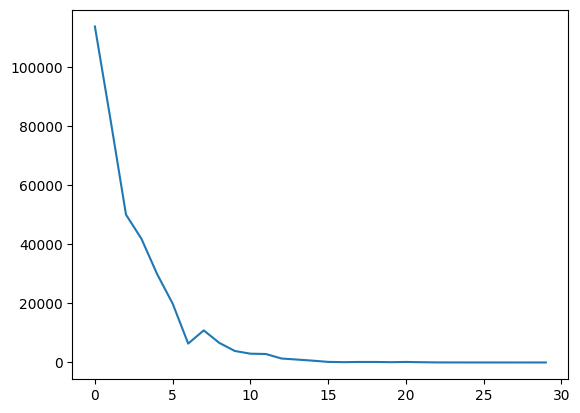

In [7]:
nn = NeuralNetwork2(
    d_in=5,
    d_hidden=10,
    L_layers=30,
    k_outputs=3,
    hidden_activation=elu,
    output_activation=softmax,
    loss_function = cross_entropy,
    learning_rate = 0.01,
)

X = np.arange(1, 6)
y = np.array([1, 0, 0]).reshape(1, 3)

y_hat = nn.forward(X)
print(y.shape, y_hat.shape)
nn.backprop(X, y, y_hat)

layer_idx = list((range(30)))
grad_norms = []
for l in layer_idx:
    grad_norms.append(np.sqrt(np.sum(nn.grads[l]**2)))

plt.plot(layer_idx, grad_norms)

plt.show()

As we can see, the last layers of the model has smaller gradient values, but as we are going toward first layers, the values become exponentially larger which indicates the concept of exploding gradient in very deep models.


### iii. Implement SGD, Momentum, and Nestrov Momentum


In [8]:
my_array = np.arange(5)
N = 2
np.array_split(my_array, range(N, len(my_array), N))

[array([0, 1]), array([2, 3]), array([4])]

In [9]:

class NeuralNetwork3:
    def __init__(self, d_in, d_hidden, L_layers, k_outputs, hidden_activation, output_activation, loss_function,
                 learning_rate, optimizer_method="SGD", momentum=None, clipnorm=1):
        self.layer_dimensions = [d_in] + [d_hidden] * L_layers + [k_outputs]
        self.weights, self.biases = self.initialize_weights()
        self.f = hidden_activation
        self.f_out = output_activation
        self.loss = loss_function
        self.learning_rate = learning_rate
        self.weights_norms = []
        self.optimizer_method = optimizer_method
        self.momentum = momentum
        self.clipnorm = clipnorm

        self.a = []
        self.h = []

        self.velocity_w = [np.zeros_like(W) for W in self.weights]
        self.velocity_b = [np.zeros_like(b) for b in self.biases]

    def fit(self, X, y, batch_size=1, epochs=10, validation_split=0.2, verbose=0):
        # Epochs log config
        if verbose > 0:
            loop_iterator = tqdm(range(epochs), desc="Training Epochs", position=0)
        else:
            loop_iterator = range(epochs)

        train_loss = []
        valid_loss = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in loop_iterator:
            # Shuffle all input vectors
            random_idx = np.random.permutation(len(X))
            X_shuffled = X[random_idx]
            y_shuffled = y[random_idx]

            # Splitting to train and validation
            valid_idx = int(len(X) * validation_split)
            X_train = X_shuffled[valid_idx:, :]
            y_train = y_shuffled[valid_idx:, :]
            X_valid = X_shuffled[:valid_idx, :]
            y_valid = y_shuffled[:valid_idx, :]

            # Splitting training data into n batches
            n_batches = int(np.ceil(len(X_train) / batch_size))
            X_batches = np.array_split(X_train, range(batch_size, len(X_train), batch_size))
            y_batches = np.array_split(y_train, range(batch_size, len(y_train), batch_size))
            y_train_hat = np.zeros_like(y_train, dtype=np.float64)
            y_hat_batches = np.array_split(y_train, range(batch_size, len(y_train), batch_size))

            # Batches log config
            if verbose > 0:
                loop_iterator = tqdm(range(n_batches), desc="Batches", position=4)
            else:
                loop_iterator = range(n_batches)

            # Run forward and back propagation on train set
            for batch_idx in loop_iterator:
                X_batch = X_batches[batch_idx]
                y_batch = y_batches[batch_idx]
                y_hat_batches[batch_idx] = self.forward(X_batch)
                y_train_hat[batch_idx * batch_size: batch_idx * batch_size + batch_size] = y_hat_batches[batch_idx]
                self.backprop(X_batch, y_batch)

            # Validate on validation set
            y_valid_pred = self.forward(X_valid)

            # Log the metrics of learning
            train_loss.append(cross_entropy(y_train, y_train_hat) / len(y_train))
            valid_loss.append(cross_entropy(y_valid, y_valid_pred) / len(y_valid))
            print("Train Loss={:.3f}, Validation Loss={:.3f}".format(train_loss[-1], valid_loss[-1]))

            train_accuracy.append(self.accuracy(y_train, y_train_hat))
            valid_accuracy.append(self.accuracy(y_valid, y_valid_pred))
            print("Train Accuracy={:.2f}, Validation Accuracy={:.2f}".format(train_accuracy[-1], valid_accuracy[-1]))

            self.update_weight_norm()

            self.reset()

        self.train_loss = train_loss
        self.valid_loss = valid_loss
        self.train_accuracy = train_accuracy
        self.valid_accuracy = valid_accuracy

    def accuracy(self, y, y_pred):
        true_labels = np.argmax(y, axis=-1)
        pred_labels = np.argmax(y_pred, axis=-1)

        correct_predictions = np.sum(pred_labels == true_labels)
        total_samples = len(true_labels)

        accuracy_percentage = (correct_predictions / total_samples) * 100.0

        return accuracy_percentage

    def update_weight_norm(self):
        result = 0
        for w in self.weights:
            result += np.sum(w ** 2)

        self.weights_norms.append(np.sqrt(result))

    def forward(self, X):
        L = len(self.layer_dimensions) - 1

        h_in = np.atleast_2d(X).T
        for l in range(L):
            self.a.append(self.weights[l] @ h_in + self.biases[l])

            # Apply hidden_activation for non-last layers
            if l != L - 1:
                self.h.append(self.f(self.a[-1]))

            h_in = self.h[-1]

        output = self.f_out(self.a[-1])
        self.h.append(output)
        return output.T

    def backprop(self, X, y):
        L = len(self.layer_dimensions) - 1
        X = np.atleast_2d(X)

        self.grad_w = [np.zeros_like(W) for W in self.weights]
        self.grad_b = [np.zeros_like(b) for b in self.biases]

        self.reset()

        if self.optimizer_method == "SGD":
            y_hat = self.forward(X)
            g = d_loss(y, y_hat)

            for l in reversed(range(L)):

                # Local gradient of non-hidden layers
                if l != L - 1:
                    g = g * d_elu(self.a[l])

                if l == 0:
                    self.grad_w[l] = g @ X
                else:
                    self.grad_w[l] = g @ self.h[l - 1].T

                self.grad_b[l] = np.sum(g, axis=1, keepdims=True)

                g = (self.weights[l].T @ g)

            for l in reversed(range(L)):
                # Clipnormin gradients
                self.grad_w[l] = np.clip(self.grad_w[l], -self.clipnorm, self.clipnorm)
                self.grad_b[l] = np.clip(self.grad_b[l], -self.clipnorm, self.clipnorm)

                # Update weights
                self.weights[l] -= self.learning_rate * self.grad_w[l]
                self.biases[l] -= self.learning_rate * self.grad_b[l]

        elif self.optimizer_method == "momentum":
            y_hat = self.forward(X)
            g = d_loss(y, y_hat)

            for l in reversed(range(L)):

                # Local gradient of non-hidden layers
                if l != L - 1:
                    g = g * d_elu(self.a[l])

                if l == 0:
                    self.grad_w[l] = g @ X
                else:
                    self.grad_w[l] = g @ self.h[l - 1].T

                self.grad_b[l] = np.sum(g, axis=1, keepdims=True)

                g = (self.weights[l].T @ g)

            for l in reversed(range(L)):
                # Clipnorming gradients
                self.grad_w[l] = np.clip(self.grad_w[l], -self.clipnorm, self.clipnorm)
                self.grad_b[l] = np.clip(self.grad_b[l], -self.clipnorm, self.clipnorm)

                # Update velocities
                self.velocity_w[l] = self.momentum * self.velocity_w[l] - self.learning_rate * self.grad_w[l]
                self.velocity_b[l] = self.momentum * self.velocity_b[l] - self.learning_rate * self.grad_b[l]

                # Update weights
                self.weights[l] += self.velocity_w[l]
                self.biases[l] += self.velocity_b[l]


        elif self.optimizer_method == 'nestrov':

            w_old = self.weights[:]
            b_old = self.biases[:]

            self.weights = [w + self.momentum * self.velocity_w[l] for l, w in enumerate(self.weights)]
            self.biases = [b + self.momentum * self.velocity_b[l] for l, b in enumerate(self.biases)]

            y_hat = self.forward(X)
            g = d_loss(y, y_hat)

            for l in reversed(range(L)):

                # Local gradient of non-hidden layers
                if l != L - 1:
                    g = g * d_elu(self.a[l])

                if l == 0:
                    self.grad_w[l] = g @ X
                else:
                    self.grad_w[l] = g @ self.h[l - 1].T

                self.grad_b[l] = np.sum(g, axis=1, keepdims=True)

                g = (self.weights[l].T @ g)

            for l in reversed(range(L)):
                # Clipnorming gradient
                self.grad_w[l] = np.clip(self.grad_w[l], -self.clipnorm, self.clipnorm)
                self.grad_b[l] = np.clip(self.grad_b[l], -self.clipnorm, self.clipnorm)

                # Update velocities
                self.velocity_w[l] = self.momentum * self.velocity_w[l] - self.learning_rate * self.grad_w[l]
                self.velocity_b[l] = self.momentum * self.velocity_b[l] - self.learning_rate * self.grad_b[l]

                # Update weights
                self.weights = [w + self.momentum * self.velocity_w[l] for l, w in enumerate(w_old)]
                self.biases = [b + self.momentum * self.velocity_b[l] for l, b in enumerate(b_old)]

    def initialize_weights(self):
        w = (initialize_weights(self.layer_dimensions))
        _, values = zip(*w.items())
        return list(values[0::2]), list(values[1::2])

    def reset(self):
        self.a = []
        self.h = []

    def __str__(self):
        res = ''
        res += "Layer Dimensions:" + str(self.layer_dimensions) + '\n'
        res += str({f"W{i}": w.shape for i, w in enumerate(self.weights)}) + '\n'
        res += str({f"B{i}": b.shape for i, b in enumerate(self.biases)}) + '\n'
        return res

In [10]:
def get_data():
    path = '/content/diabetes_012_health_indicators_BRFSS2015.csv'
    df = pd.read_csv(path)

    y = np.array(df.pop("Diabetes_012"))

    y = np.array(pd.get_dummies(y))
    X = np.array(df)

    return (X - np.mean(X, axis=0))/np.std(X, axis=0), y

#### Stochastic Gradient Decent


In [11]:
%%time
nn_sgd = NeuralNetwork3(
    d_in=21,
    d_hidden=20,
    L_layers=5,
    k_outputs=3,
    hidden_activation=elu,
    output_activation=softmax,
    loss_function = cross_entropy,
    learning_rate = 0.00003,
    optimizer_method="SGD",
)

epochs = 20
X, y = get_data()
nn_sgd.fit(X, y, batch_size=256, epochs=epochs, verbose=1)

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=1.205, Validation Loss=0.556
Train Accuracy=59.52, Validation Accuracy=81.66


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.506, Validation Loss=0.480
Train Accuracy=82.60, Validation Accuracy=83.00


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.474, Validation Loss=0.466
Train Accuracy=83.10, Validation Accuracy=83.23


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.460, Validation Loss=0.459
Train Accuracy=83.35, Validation Accuracy=83.18


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.452, Validation Loss=0.444
Train Accuracy=83.38, Validation Accuracy=83.52


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.444, Validation Loss=0.441
Train Accuracy=83.51, Validation Accuracy=83.41


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.440, Validation Loss=0.434
Train Accuracy=83.50, Validation Accuracy=83.64


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.436, Validation Loss=0.430
Train Accuracy=83.52, Validation Accuracy=83.76


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.431, Validation Loss=0.437
Train Accuracy=83.64, Validation Accuracy=83.46


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.429, Validation Loss=0.430
Train Accuracy=83.66, Validation Accuracy=83.63


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.427, Validation Loss=0.429
Train Accuracy=83.72, Validation Accuracy=83.64


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.426, Validation Loss=0.420
Train Accuracy=83.66, Validation Accuracy=84.08


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.425, Validation Loss=0.418
Train Accuracy=83.77, Validation Accuracy=83.93


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.421, Validation Loss=0.425
Train Accuracy=83.95, Validation Accuracy=83.59


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.420, Validation Loss=0.421
Train Accuracy=83.90, Validation Accuracy=84.02


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.420, Validation Loss=0.416
Train Accuracy=83.90, Validation Accuracy=84.20


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.417, Validation Loss=0.421
Train Accuracy=84.04, Validation Accuracy=83.91


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.418, Validation Loss=0.414
Train Accuracy=83.95, Validation Accuracy=84.33


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.417, Validation Loss=0.411
Train Accuracy=84.07, Validation Accuracy=84.09


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.415, Validation Loss=0.417
Train Accuracy=84.10, Validation Accuracy=84.15
CPU times: user 2min 34s, sys: 6.44 s, total: 2min 40s
Wall time: 2min 50s


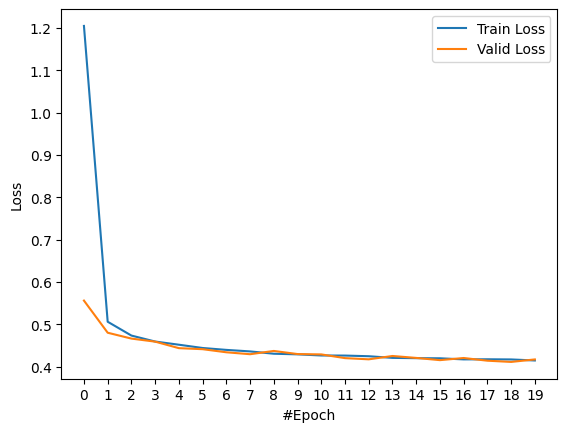

In [12]:
plt.plot(range(epochs), nn_sgd.train_loss, c="C0", label="Train Loss")
plt.plot(range(epochs), nn_sgd.valid_loss, c="C1", label="Valid Loss")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

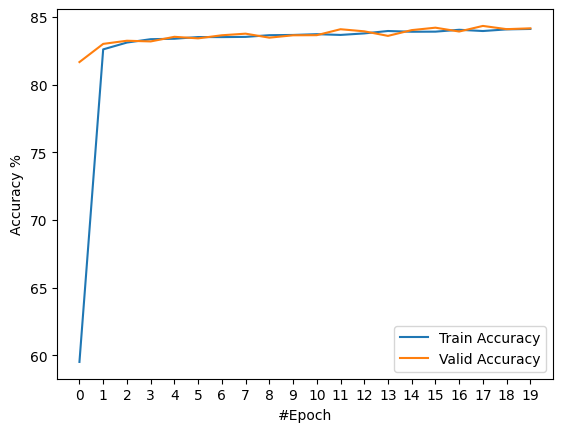

In [13]:
plt.plot(range(epochs), nn_sgd.train_accuracy, c="C0", label="Train Accuracy")
plt.plot(range(epochs), nn_sgd.valid_accuracy, c="C1", label="Valid Accuracy")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

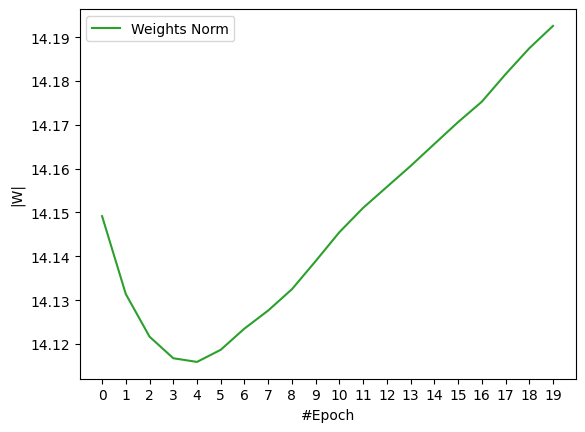

In [14]:
plt.plot(range(epochs), nn_sgd.weights_norms, c="C2", label="Weights Norm")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("|W|")
plt.legend()
plt.show()

#### Stochastic Gradient Decent with Momentum


In [15]:
%%time
nn_mom = NeuralNetwork3(
    d_in=21,
    d_hidden=20,
    L_layers=5,
    k_outputs=3,
    hidden_activation=elu,
    output_activation=softmax,
    loss_function = cross_entropy,
    learning_rate = 0.00003,
    optimizer_method="momentum",
    momentum=0.9
)


X, y = get_data()
nn_mom.fit(X, y, batch_size=256, epochs=epochs, verbose=1)

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.553, Validation Loss=0.426
Train Accuracy=80.39, Validation Accuracy=83.96


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.421, Validation Loss=0.416
Train Accuracy=83.96, Validation Accuracy=84.07


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.413, Validation Loss=0.412
Train Accuracy=84.26, Validation Accuracy=84.36


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.414
Train Accuracy=84.41, Validation Accuracy=84.16


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.405
Train Accuracy=84.38, Validation Accuracy=84.54


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.405
Train Accuracy=84.35, Validation Accuracy=84.51


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.404
Train Accuracy=84.37, Validation Accuracy=84.34


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.407, Validation Loss=0.404
Train Accuracy=84.32, Validation Accuracy=84.44


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.405, Validation Loss=0.411
Train Accuracy=84.35, Validation Accuracy=84.21


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.408
Train Accuracy=84.27, Validation Accuracy=84.28


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.410
Train Accuracy=84.32, Validation Accuracy=84.38


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.409, Validation Loss=0.405
Train Accuracy=84.27, Validation Accuracy=84.46


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.410, Validation Loss=0.403
Train Accuracy=84.27, Validation Accuracy=84.48


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.413
Train Accuracy=84.32, Validation Accuracy=84.11


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.407, Validation Loss=0.411
Train Accuracy=84.32, Validation Accuracy=84.46


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.409, Validation Loss=0.403
Train Accuracy=84.39, Validation Accuracy=84.77


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.407, Validation Loss=0.410
Train Accuracy=84.52, Validation Accuracy=84.54


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.406
Train Accuracy=84.52, Validation Accuracy=84.68


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.402
Train Accuracy=84.53, Validation Accuracy=84.71


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.408
Train Accuracy=84.56, Validation Accuracy=84.50
CPU times: user 2min 31s, sys: 6.4 s, total: 2min 37s
Wall time: 2min 38s


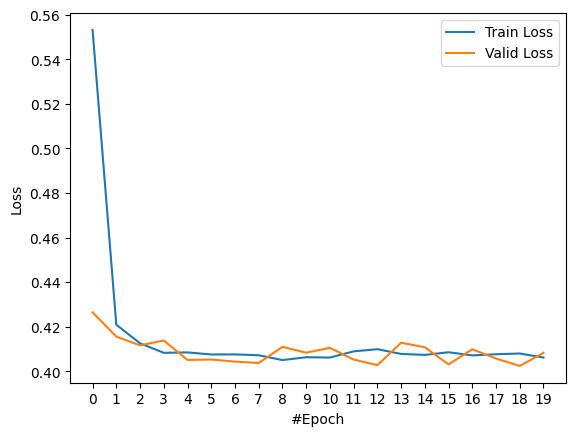

In [16]:
plt.plot(range(epochs), nn_mom.train_loss, c="C0", label="Train Loss")
plt.plot(range(epochs), nn_mom.valid_loss, c="C1", label="Valid Loss")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

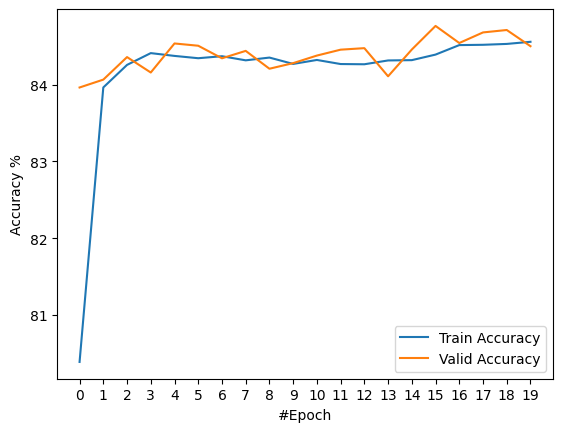

In [17]:
plt.plot(range(epochs), nn_mom.train_accuracy, c="C0", label="Train Accuracy")
plt.plot(range(epochs), nn_mom.valid_accuracy, c="C1", label="Valid Accuracy")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

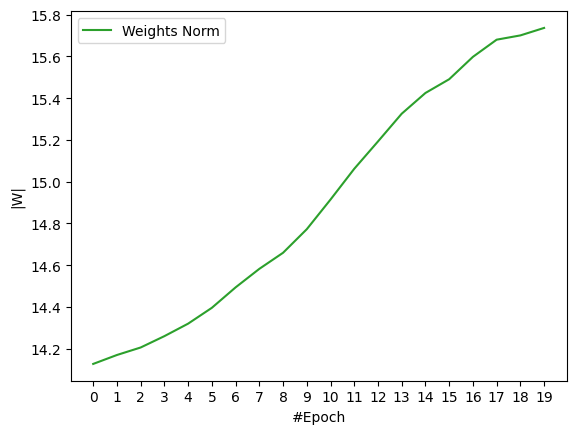

In [18]:
plt.plot(range(epochs), nn_mom.weights_norms, c="C2", label="Weights Norm")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("|W|")
plt.legend()
plt.show()

#### Stochastic Gradient Decent with Nestrov Momentum


In [19]:
%%time
nn_nag = NeuralNetwork3(
    d_in=21,
    d_hidden=20,
    L_layers=5,
    k_outputs=3,
    hidden_activation=elu,
    output_activation=softmax,
    loss_function = cross_entropy,
    learning_rate = 0.00003,
    optimizer_method="nestrov",
    momentum=0.9
)


X, y = get_data()
nn_nag.fit(X, y, batch_size=256, epochs=epochs, verbose=1)

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.564, Validation Loss=0.429
Train Accuracy=80.13, Validation Accuracy=83.90


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.423, Validation Loss=0.417
Train Accuracy=83.89, Validation Accuracy=84.05


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.414, Validation Loss=0.413
Train Accuracy=84.23, Validation Accuracy=84.32


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.409, Validation Loss=0.414
Train Accuracy=84.40, Validation Accuracy=84.12


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.409, Validation Loss=0.405
Train Accuracy=84.36, Validation Accuracy=84.49


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.406
Train Accuracy=84.32, Validation Accuracy=84.48


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.404
Train Accuracy=84.39, Validation Accuracy=84.34


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.407, Validation Loss=0.404
Train Accuracy=84.34, Validation Accuracy=84.49


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.405, Validation Loss=0.411
Train Accuracy=84.35, Validation Accuracy=84.22


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.409
Train Accuracy=84.28, Validation Accuracy=84.27


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.411
Train Accuracy=84.24, Validation Accuracy=84.26


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.409, Validation Loss=0.405
Train Accuracy=84.25, Validation Accuracy=84.56


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.410, Validation Loss=0.403
Train Accuracy=84.30, Validation Accuracy=84.54


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.413
Train Accuracy=84.37, Validation Accuracy=83.98


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.410
Train Accuracy=84.29, Validation Accuracy=84.40


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.408, Validation Loss=0.402
Train Accuracy=84.39, Validation Accuracy=84.68


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.409
Train Accuracy=84.49, Validation Accuracy=84.46


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.405
Train Accuracy=84.52, Validation Accuracy=84.63


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.407, Validation Loss=0.401
Train Accuracy=84.54, Validation Accuracy=84.78


Batches:   0%|          | 0/793 [00:00<?, ?it/s]

Train Loss=0.406, Validation Loss=0.408
Train Accuracy=84.57, Validation Accuracy=84.66
CPU times: user 5min 40s, sys: 2.66 s, total: 5min 43s
Wall time: 5min 52s


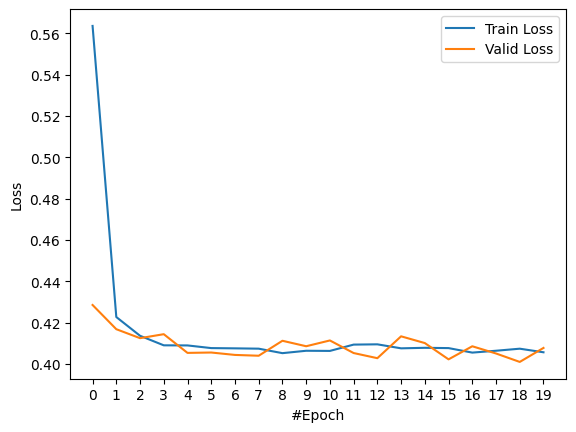

In [20]:
plt.plot(range(epochs), nn_nag.train_loss, c="C0", label="Train Loss")
plt.plot(range(epochs), nn_nag.valid_loss, c="C1", label="Valid Loss")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

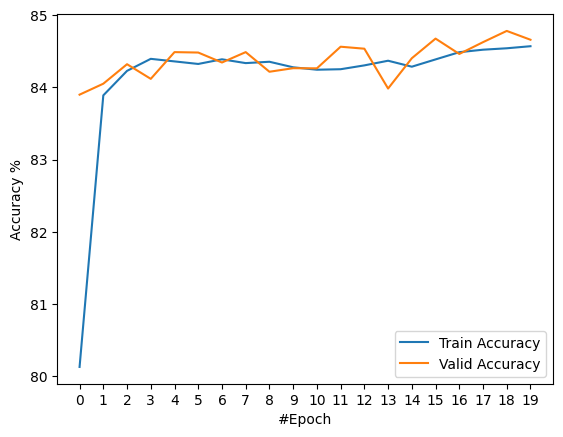

In [21]:
plt.plot(range(epochs), nn_nag.train_accuracy, c="C0", label="Train Accuracy")
plt.plot(range(epochs), nn_nag.valid_accuracy, c="C1", label="Valid Accuracy")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

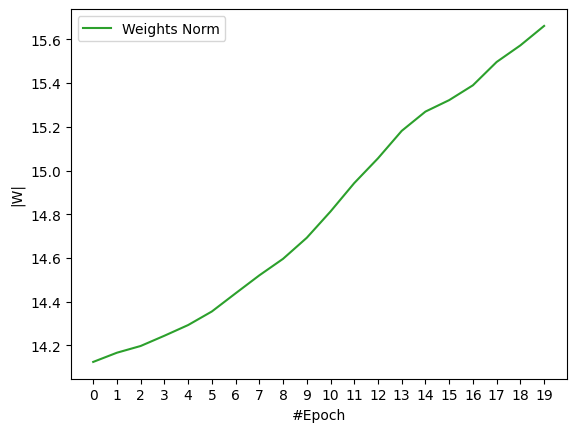

In [22]:
plt.plot(range(epochs), nn_nag.weights_norms, c="C2", label="Weights Norm")

plt.xticks(range(epochs))
plt.xlabel("#Epoch")
plt.ylabel("|W|")
plt.legend()
plt.show()

As the result of experiments shows, with the same factors like learning rate, number of epochs, SGD take more time to converge and worse converge relative to Momentum and Nestrov Momentum method. Between two latter methods, Nestrov achieved a slightly smaller loss value and also converged sooner in comparison to momentum. Overall, it is true that SGD is outperformed by the other methods, however the difference between themselves are not significant.